In [19]:
import ccxt
import pandas as pd

In [20]:
ex = ccxt.binance()
df =  pd.DataFrame(ex.fetch_ohlcv(symbol='BTCUSDT', timeframe='1d', limit=1000),
                   columns=['unix', 'open', 'high', 'low', 'close', 'volume'])
df['date'] = pd.to_datetime(df.unix, unit='ms')

Text(0.5, 1.0, 'BTC Daily Close Price')

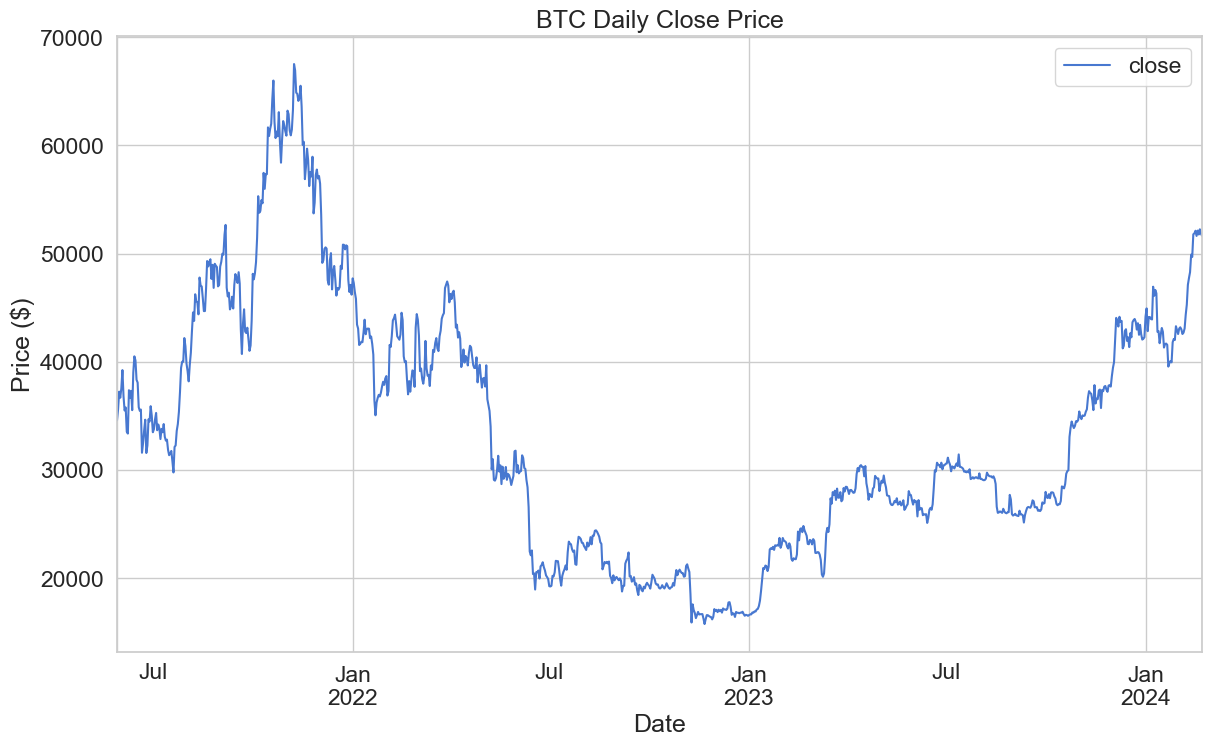

In [21]:
# okunana verilerin görsel olarak grafikleştirilmesi

from pylab import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

rcParams['figure.figsize'] = 14,8
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
ax = df.plot(x='date', y='close')
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
ax.set_title('BTC Daily Close Price')

In [22]:
# Normalizasyon işlemi
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
close_price = df.close.values.reshape(-1,1)
scaled_close = scaler.fit_transform(close_price)

In [31]:
import numpy as np
seq_len = 60

def split_into_sequences(data, seq_len):
    n_seq = len(data) - seq_len +1
    return np.array([data[i:(i+seq_len)] for i in range (n_seq)])
def get_train_test_sets(data, seq_len, train_frac):
    sequences = split_into_sequences(data, seq_len)
    n_train = int(sequences.shape[0]*train_frac)
    x_train = sequences[:n_train, :-1:]
    y_train = sequences[:n_train, -1:]    
    x_test = sequences[n_train:, :-1, :]
    y_test = sequences[n_train:, -1, :]   
    return x_train, y_train, x_test, y_test
x_train, y_train, x_test, y_test= get_train_test_sets(scaled_close, seq_len, train_frac=0.9)

In [32]:
from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.keras.models import Sequential
dropout = 0.2
windows_size = seq_len - 1
model = keras.Sequential()

model.add(LSTM(windows_size, return_sequences=True, input_shape=(windows_size, x_train.shape[-1])))
model.add(Dropout(rate=dropout))
model.add(Bidirectional(LSTM(windows_size * 2, return_sequences=True)))
model.add(Dropout(rate=dropout))
model.add(Bidirectional(LSTM(windows_size, return_sequences=False)))
model.add(Dense(units=1))
model.add(Activation('linear'))

batch_size = 16
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(x_train, y_train, epochs=10, 
                    batch_size=batch_size, shuffle=False, validation_split=0.2)


Epoch 1/10
43/43 [==============================] - 9s 76ms/step - loss: 0.0279 - val_loss: 0.0208
Epoch 2/10
43/43 [==============================] - 2s 46ms/step - loss: 0.0332 - val_loss: 0.0195
Epoch 3/10
43/43 [==============================] - 2s 46ms/step - loss: 0.0388 - val_loss: 0.0192
Epoch 4/10
43/43 [==============================] - 2s 46ms/step - loss: 0.0396 - val_loss: 0.0118
Epoch 5/10
43/43 [==============================] - 2s 48ms/step - loss: 0.0312 - val_loss: 0.0030
Epoch 6/10
43/43 [==============================] - 2s 47ms/step - loss: 0.0279 - val_loss: 0.0047
Epoch 7/10
43/43 [==============================] - 2s 48ms/step - loss: 0.0236 - val_loss: 0.0056
Epoch 8/10
43/43 [==============================] - 2s 47ms/step - loss: 0.0217 - val_loss: 0.0014
Epoch 9/10
43/43 [==============================] - 2s 46ms/step - loss: 0.0138 - val_loss: 8.8007e-04
Epoch 10/10
43/43 [==============================] - 2s 46ms/step - loss: 0.0072 - val_loss: 0.0013


3/3 [==============================] - 0s 22ms/step


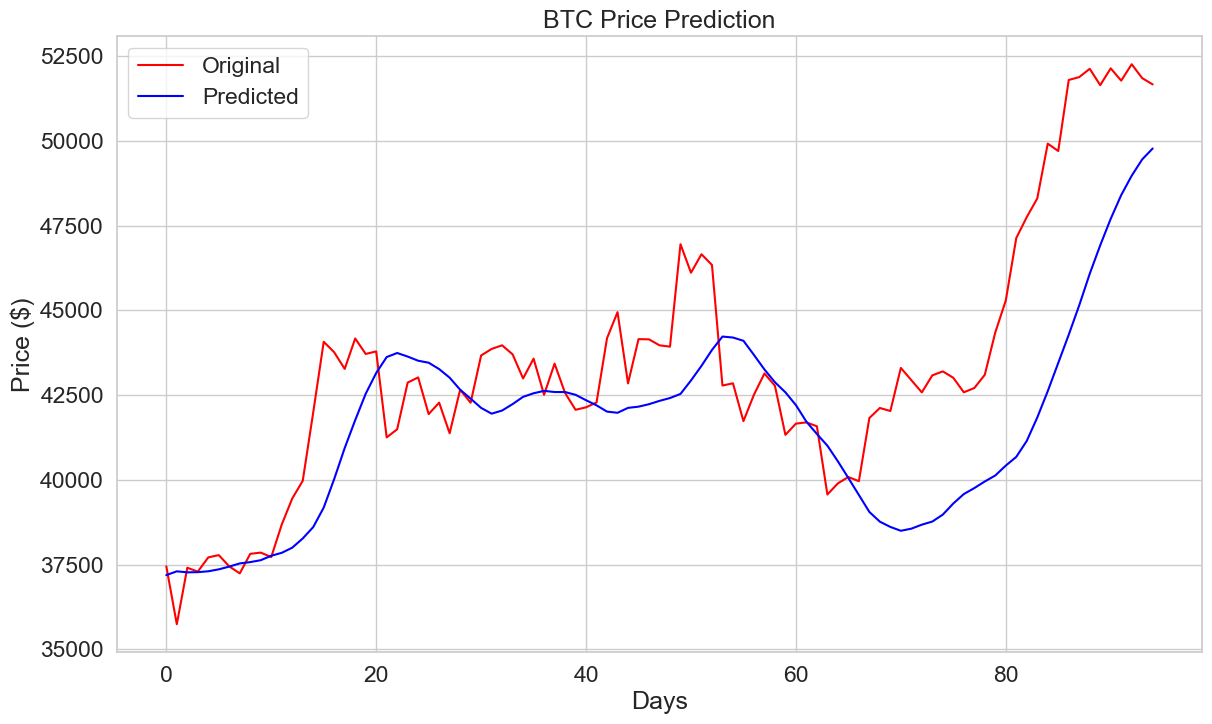

In [34]:
y_pred = model.predict(x_test)
y_test_orig = scaler.inverse_transform(y_test)
y_pred_orig = scaler.inverse_transform(y_pred)
plt.plot(y_test_orig, label='Original', color='red')
plt.plot(y_pred_orig, label='Predicted', color='blue')
plt.title('BTC Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price ($)')
plt.legend(loc='best')
plt.show()